In [ ]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from quantum_logical import Pulse, DressedQuantumSystem
from quantum_logical.hamiltonian import QubitSNAILModule
from quantum_logical.mode import QubitMode, SNAILMode
from qutip import Options

from tqdm import tqdm
from scipy.optimize import minimize
import scienceplots


opts = {"nsteps": 1e6, "atol": 1e-9, "rtol": 1e-7}  # , "progress_bar": "text"}

In [ ]:
# Initial qubit frequencies and SNAIL frequency
freqs = np.array([5.06167, 4.54944, 4.16829])  # q1, q2, q3 frequencies
snail_freq = 4.27515  # SNAIL frequency

# freqs, snail_freq = ([4.0, 6.0, 4.665925514174542], 5.667593107281823)

In [ ]:
qubit_dim = 2
qubit1 = QubitMode(name="q1", dim=qubit_dim, freq=freqs[0])
qubit2 = QubitMode(name="q2", dim=qubit_dim, freq=freqs[1])
qubit3 = QubitMode(name="q3", dim=qubit_dim, freq=freqs[2])
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=snail_freq, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
# g/delta = 0.1 for all qubits
g2_0 = 0.1 * np.abs(snail.freq - qubit1.freq)
g2_1 = 0.1 * np.abs(snail.freq - qubit2.freq)
g2_2 = 0.1 * np.abs(snail.freq - qubit3.freq)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = DressedQuantumSystem(
    qubits + [snail], couplings=_couplings, hamiltonian_cls=QubitSNAILModule
)

In [ ]:
# (undressed) expectation operators
e_ops = [qs.modes_num[m] for m in qs.modes]

# collapse operators
c_ops = []
# for mode in qs.modes:
#    c_ops.append(mode.collapse_operators(qs))

In [ ]:
# create an initial state
# |0> \otimes |1> \otimes |0> \otimes |0>
psi0 = qs.prepare_approx_state([(qubit2, 1)])
rho0 = psi0 * psi0.dag()

In [ ]:
# FIXME, main downside here is that we correctly want to define the action of
# the ancillae qubits as identity; but the action of the SNAIL should be undefined.
# This is because the action on SNAIL definitely won't be identity, but physically
# since SNAIL has short lifetime we know it will decay reliably to the ground state.
# However, our simulation doesn't necessarily include SNAIL loss channels. Therefore,
# the ideal action should be defined over the qubits only- not the SNAIL.

from qutip_qip.operations import iswap

desired_U = iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action to the complete system
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
# Skip the first two qubits as they're already included
# Skip the last index as it's the SNAIL mode
for mode in qs.modes[2:-1]:
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2

# act on qubit space only
qubit_rho0 = rho0.ptrace(range(len(qubits)))
expected_qubit_rho = qt.Qobj(desired_U * qubit_rho0 * desired_U.dag())

In [ ]:
width_d = 300  # ns
off_d = 20
# args = {"shape": Pulse.box, "shape_params": {"t0": off_d, "width": width_d}}
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": off_d, "width": width_d}}
full_time = np.linspace(0, width_d + 2 * off_d, 500)
wp = np.abs(qubit1.freq - qubit2.freq)
pulse = Pulse(omega=wp, amp=6.5)

# Plot the Gaussian pulse shape
Pulse.plot_pulse([(pulse, args)], full_time)

In [ ]:
# single period Pulse
wp = np.abs(qubit1.freq - qubit2.freq)
T = 2 * np.pi / wp
period_time = np.linspace(0, T, 250)  # a single period of the pulse
args = {"shape": Pulse.constant}
pulse = Pulse(omega=wp, amp=6.5)
Pulse.plot_pulse([(pulse, args)], period_time)

In [ ]:
def mesolve_task(omega_amp_tuple):
    omega, amp = omega_amp_tuple
    pulse = Pulse(omega=omega, amp=amp)
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": off_d, "width": width_d}}
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    result = qt.mesolve(H, psi0, full_time, c_ops, options=opts, args=args)
    return [(t, state) for t, state in zip(result.times, result.states)]


def _construct_propagator(omega_amp_tuple):
    omega, amp = omega_amp_tuple
    T = 2 * np.pi / omega
    pulse = Pulse(omega=omega, amp=amp)
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    U_t = qt.propagator(H, T, c_ops, args=args, options=opts)

    # off pump
    pulse_off = Pulse(omega=omega, amp=0)
    H_off = [qs.hamiltonian.H0, [H_pump, pulse_off.drive]]
    U_off = qt.propagator(H_off, off_d, c_ops, args=args, options=opts)
    return U_t, U_off


def _construct_full_propagator(omega_amp_tuple):
    # create total time evolution operator
    omega, amp = omega_amp_tuple
    T = 2 * np.pi / omega
    U_t, U_off = _construct_propagator(omega_amp_tuple)
    n_periods = int(width_d / T)
    U_total = U_off * (U_t**n_periods) * U_off
    return U_total, full_time[-1]


def propagator_task(omega_amp_tuple) -> qt.Qobj:
    omega, amp = omega_amp_tuple
    T = 2 * np.pi / omega
    n_periods = int(width_d / T)
    U_t, U_off = _construct_propagator((omega, amp))
    states = [rho0]
    times = [0]

    # initial off pulse
    rho_tt = qt.Qobj(U_off * rho0 * U_off.dag())
    states.append(rho_tt)
    times.append(off_d)

    for _ in range(n_periods):
        rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())
        states.append(rho_tt)
        times.append(times[-1] + T)

    # final off pulse
    rho_tt = qt.Qobj(U_off * rho_tt * U_off.dag())
    states.append(rho_tt)
    times.append(times[-1] + off_d)

    return [(t, state) for t, state in zip(times, states)]


def plot_expected_occupations(result_obj):
    # Prepare plot
    plt.figure(figsize=(6, 6))

    times = [t for t, _ in result_obj]

    # Collect data for all modes
    for mode in qs.modes_num:
        populations = [
            np.abs(qt.expect(qs.modes_num[mode], state)) for _, state in result_obj
        ]
        # Plot each mode's population over time
        plt.plot(times, populations, label=mode.name, marker="o")

    # Setting plot labels and title
    plt.xlabel("Time (ns)")
    plt.ylabel("Expected Population")
    plt.title("Expected Population of Modes Over Time")
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()


# final state fidelity
def extract_state_fidelity(result_obj):
    final_state = result_obj[-1][1]
    qubit_rhof = final_state.ptrace(range(len(qubits)))
    return qt.fidelity(qubit_rhof, expected_qubit_rho)

In [ ]:
me_result = mesolve_task((wp + 0.0535, 14.15))
plot_expected_occupations(me_result)
extract_state_fidelity(me_result)

In [ ]:
def reduced_mesolve_task(omega_amp_tuple):
    omega, amp = omega_amp_tuple
    pulse = Pulse(omega=omega, amp=amp)
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": off_d, "width": width_d}}
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    result = qt.mesolve(H, psi0, full_time, c_ops, options=opts, args=args)
    return result.states[-1]


amp_list = np.linspace(0, 25, 10)
detuning_list = np.linspace(5, 10, 25)  # Mhz
# convert detuning to rad/ns
omega_list = wp + (detuning_list * 2 * np.pi / 1000)
omega_amp_tuples = [(w, a) for w in omega_list for a in amp_list]

parallel_me_results = qt.parallel_map(
    reduced_mesolve_task, omega_amp_tuples, progress_bar="text"
)

fidelity_list = []
for state in parallel_me_results:
    final_state = state.ptrace(range(len(qubits)))
    fidelity = qt.fidelity(final_state, expected_qubit_rho)
    fidelity_list.append(fidelity)

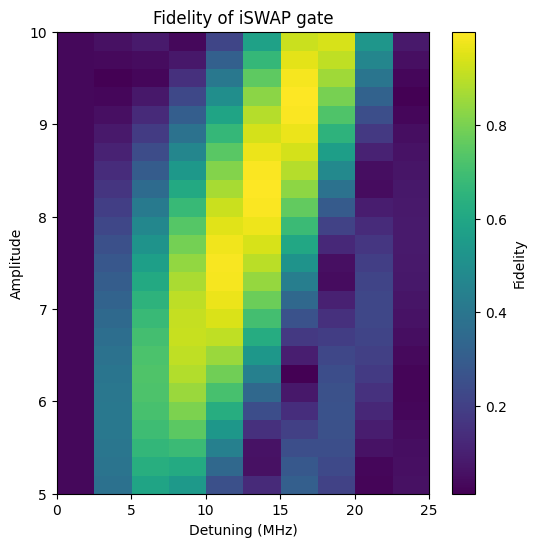

In [60]:
# Transform fidelity_list to a 2D array
fidelity_array = np.array(fidelity_list).reshape(len(omega_list), len(amp_list))

# Use plt.style.context for the 'ipynb' style
with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size for better aesthetics

    # Plot the 2D color plot
    cax = ax.imshow(
        fidelity_array,
        extent=(amp_list[0], amp_list[-1], detuning_list[0], detuning_list[-1]),
        aspect="auto",
        origin="lower",
        cmap="viridis",
    )

    # Add a color bar
    cbar = fig.colorbar(cax)
    cbar.set_label("Fidelity")

    # Set axis labels
    ax.set_xlabel("Detuning (MHz)")
    ax.set_ylabel("Amplitude")

    # Set title
    ax.set_title("Fidelity of iSWAP gate")
    # Display the plot
    plt.show()

In [59]:
# Step 1: Find the index of the maximum fidelity value
max_fidelity_index = np.argmax(fidelity_array)

# Step 2: Convert the flat index to a pair of indices for detuning and amplitude
omega_index, amp_index = np.unravel_index(max_fidelity_index, fidelity_array.shape)

# Step 3: Retrieve the corresponding detuning and amplitude values
max_detuning = detuning_list[omega_index]
max_amplitude = amp_list[amp_index]
max_fidelity = fidelity_array[omega_index, amp_index]

# Print the results
print(f"Maximum Fidelity: {max_fidelity}")
print(f"Corresponding Detuning (MHz): {max_detuning}")
print(f"Corresponding Amplitude: {max_amplitude}")

Maximum Fidelity: 0.9995480336939736
Corresponding Detuning (MHz): 8.333333333333334
Corresponding Amplitude: 13.88888888888889


In [ ]:
prop_result = propagator_task((wp + 0.0535, 14.15))
plot_expected_occupations(prop_result)
extract_state_fidelity(prop_result)

In [ ]:
U_tot, duration = _construct_full_propagator((wp + 0.0535, 14.15))
# define fidelity using the unitary with SNAIL mode removed
qubit_desired_U = desired_U.ptrace(range(len(qubits)))
qubit_U_tot = U_tot.ptrace(range(len(qubits)))
qt.average_gate_fidelity(qubit_U_tot, target=qubit_desired_U)

In [ ]:
qubit_U_tot.isunitary

In [ ]:
prop_result = propagator_task((wp + 0.0535, 14.15))
plot_expected_occupations(prop_result)
extract_state_fidelity(prop_result)